연결하는 부분

In [2]:
from google.colab import drive
drive.mount('/content/drive')  

import os

os.chdir('/content/drive/My Drive/Colab Notebooks/ML_class/transfer learning_hw')
%pwd

Mounted at /content/drive


'/content/drive/My Drive/Colab Notebooks/ML_class/transfer learning_hw'

데이터를 로드하는 부분으로 컴퓨터비전 시간에 이용한 cnn과 비교하기위해 똑같은 flower dataset을 이용했다

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/content/drive/My Drive/Colab Notebooks/ML_class/transfer learning'
data_dir = './flowers/'
print(os.path.join(data_dir, 'train'))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print(image_datasets)
print(len(image_datasets['train']))
print(len(image_datasets['val']))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

./flowers/train
{'train': Dataset ImageFolder
    Number of datapoints: 3042
    Root location: ./flowers/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 1306
    Root location: ./flowers/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
3042
1306


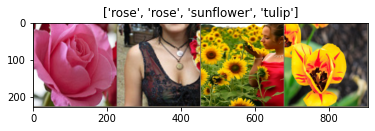

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #print("outputs,labels:",outputs,labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth



1024
Epoch 0/24
----------
train Loss: 0.9616 Acc: 0.6374
val Loss: 0.3525 Acc: 0.8790

Epoch 1/24
----------
train Loss: 0.7240 Acc: 0.7272
val Loss: 0.2908 Acc: 0.9051

Epoch 2/24
----------
train Loss: 0.6322 Acc: 0.7771
val Loss: 0.2682 Acc: 0.9181

Epoch 3/24
----------
train Loss: 0.5982 Acc: 0.7850
val Loss: 0.2392 Acc: 0.9211

Epoch 4/24
----------
train Loss: 0.5858 Acc: 0.7903
val Loss: 0.2504 Acc: 0.9196

Epoch 5/24
----------
train Loss: 0.5212 Acc: 0.8107
val Loss: 0.2659 Acc: 0.9074

Epoch 6/24
----------
train Loss: 0.5190 Acc: 0.8195
val Loss: 0.2134 Acc: 0.9334

Epoch 7/24
----------
train Loss: 0.4184 Acc: 0.8583
val Loss: 0.1917 Acc: 0.9342

Epoch 8/24
----------
train Loss: 0.3853 Acc: 0.8672
val Loss: 0.1988 Acc: 0.9303

Epoch 9/24
----------
train Loss: 0.3825 Acc: 0.8757
val Loss: 0.1946 Acc: 0.9372

Epoch 10/24
----------
train Loss: 0.3999 Acc: 0.8596
val Loss: 0.1776 Acc: 0.9410

Epoch 11/24
----------
train Loss: 0.3694 Acc: 0.8751
val Loss: 0.1735 Acc: 0.94

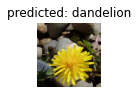

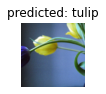

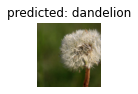

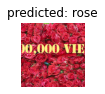

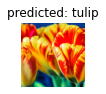

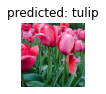

****************************** 파라마터 no
Epoch 0/24
----------
train Loss: 1.1114 Acc: 0.5651
val Loss: 0.5760 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.9006 Acc: 0.6631
val Loss: 0.5173 Acc: 0.8369

Epoch 2/24
----------
train Loss: 0.8539 Acc: 0.6821
val Loss: 0.4654 Acc: 0.8599

Epoch 3/24
----------
train Loss: 0.8695 Acc: 0.6815
val Loss: 0.4662 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.8349 Acc: 0.6893
val Loss: 0.4243 Acc: 0.8583

Epoch 5/24
----------
train Loss: 0.8315 Acc: 0.6933
val Loss: 0.4168 Acc: 0.8729

Epoch 6/24
----------
train Loss: 0.8104 Acc: 0.7058
val Loss: 0.4196 Acc: 0.8698

Epoch 7/24
----------
train Loss: 0.7666 Acc: 0.7242
val Loss: 0.4263 Acc: 0.8499

Epoch 8/24
----------
train Loss: 0.7759 Acc: 0.7114
val Loss: 0.4257 Acc: 0.8668

Epoch 9/24
----------
train Loss: 0.7707 Acc: 0.7216
val Loss: 0.4056 Acc: 0.8729

Epoch 10/24
----------
train Loss: 0.7503 Acc: 0.7308
val Loss: 0.4174 Acc: 0.8606

Epoch 11/24
----------
train Loss: 0.7861 Acc: 

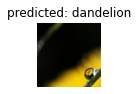

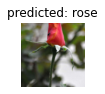

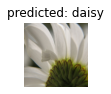

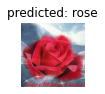

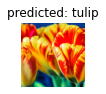

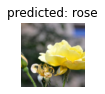

In [7]:
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)
#print(model_ft)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft , exp_lr_scheduler,
                       num_epochs=25)
visualize_model(model_ft)

print("*"*30,"파라마터 no")
model_conv = torchvision.models.googlenet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv)

plt.ioff()
plt.show()